In [3]:
import numpy as np
import zipfile
import shutil
import splitfolders, glob, os, cv2
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import *
from imgaug import augmenters as iaa
import imgaug as ia
import glob
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

ЗАГРУЗКА ДАННЫХ

In [12]:
!pip install kaggle

os.environ['KAGGLE_USERNAME'] = "arinamon"
os.environ['KAGGLE_KEY'] = "09e6348ba0004645e461cccd0e3627f3"

!kaggle datasets download -d jehanbhathena/tire-texture-image-recognition


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
100%|███████████████████████████████████████▉| 707M/708M [01:36<00:00, 9.86MB/s]
100%|████████████████████████████████████████| 708M/708M [01:36<00:00, 7.65MB/s]


In [13]:
file_name = 'tire-texture-image-recognition.zip'
zip = zipfile.ZipFile(file_name)
zip.extractall()

if os.path.exists(file_name):
    os.remove(file_name)

In [14]:
tire_path = '/Tire Textures/'

In [15]:
def mergefolders(root_src_dir, root_dst_dir):
    for src_dir, dirs, files in os.walk(root_src_dir):
        print("src_dir = ", src_dir)
        dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
        print("dst_dir = ", dst_dir)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        for file_ in files:
            src_file = os.path.join(src_dir, file_)
            dst_file = os.path.join(dst_dir, file_)
            if os.path.exists(dst_file):
                os.remove(dst_file)
            shutil.copy(src_file, dst_dir)

ОБЪЕДИНЕНИЕ ИЗОБРАЖЕНИЙ

In [16]:
def make_new_folder(folder_name, parent_folder):
    path = os.path.join(parent_folder, folder_name)
    mode = 0o777
    os.mkdir(path, mode)


current_folder = os.getcwd() + tire_path


list_dir = ['testing_data', 'valid_data', 'training_data']

content_list = {}
for index, val in enumerate(list_dir):
    path = os.path.join(current_folder, val)
    content_list[ list_dir[index] ] = os.listdir(path)

merge_folder = "tire_textures/"

merge_folder_path = os.path.join(os.getcwd(), merge_folder)

make_new_folder(merge_folder, os.getcwd())

for sub_dir in content_list:
    for contents in content_list[sub_dir]:
        if not contents.startswith('.'):
            path_to_content = os.getcwd() + tire_path + sub_dir + "/" + contents + "/"
            isExist = os.path.exists( merge_folder_path + contents)
            dir_to_move = os.path.join(os.getcwd(), path_to_content)
            if isExist:
                mergefolders(dir_to_move, merge_folder_path + contents)
            else:
                shutil.move(dir_to_move, merge_folder_path)

src_dir =  /Users/arina/Documents/Diplom/ModelCNN/Tire Textures/training_data/cracked/
dst_dir =  /Users/arina/Documents/Diplom/ModelCNN/tire_textures/cracked
src_dir =  /Users/arina/Documents/Diplom/ModelCNN/Tire Textures/training_data/normal/
dst_dir =  /Users/arina/Documents/Diplom/ModelCNN/tire_textures/normal


In [76]:
if os.path.exists(tire_path):
    shutil.rmtree(tire_path)

таким образом, получилось два класса: cracked/normal

In [1]:
normal_tire_path = "./tire_textures/normal/"
cracked_tire_path = "./tire_textures/cracked/"

In [4]:
_, _, normal_files = next(os.walk(normal_tire_path))
_, _, cracked_files = next(os.walk(cracked_tire_path))

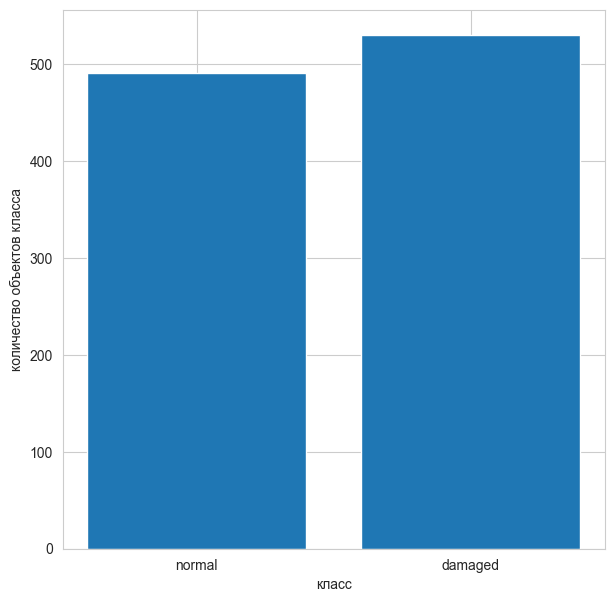

In [5]:
fig, ax = plt.subplots(figsize=(7, 7))

classes = ['normal', 'damaged']
nums = [len(normal_files), len(cracked_files)]

ax.bar(classes, nums)
plt.xlabel('класс')
plt.ylabel('количество объектов класса')

plt.show()

разбить данные на классы

In [21]:
splitfolders.ratio("tire_textures", output="splitted_data", seed=1337, ratio=(.8, .0, .2))

Copying files: 1021 files [00:00, 1101.56 files/s]


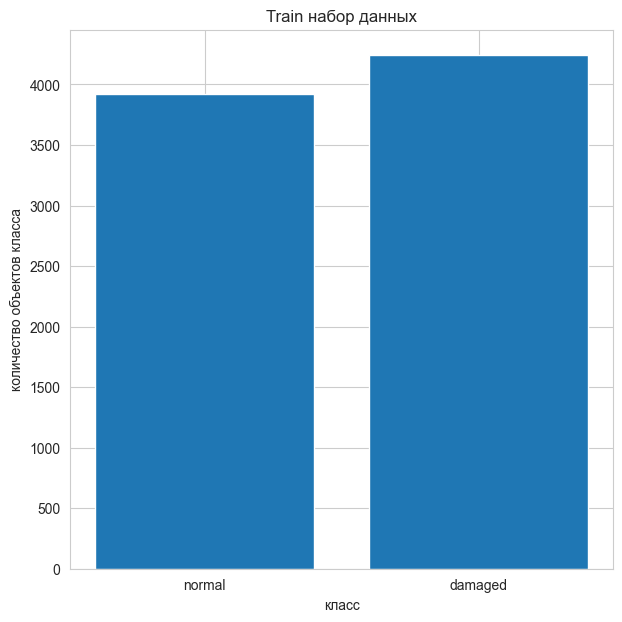

In [6]:
from pathlib import Path
normal_tire_path = 'splitted_data/train/normal'
cracked_tire_path = 'splitted_data/train/cracked'
_, _, normal_files = next(os.walk(normal_tire_path))
_, _, cracked_files = next(os.walk(cracked_tire_path))

fig, ax = plt.subplots(figsize=(7, 7))

classes = ['normal', 'damaged']
nums = [len(normal_files), len(cracked_files)]

ax.bar(classes, nums)
plt.xlabel('класс')
plt.ylabel('количество объектов класса')
plt.title('Train набор данных')
plt.show()


In [24]:
len(normal_files), len(cracked_files)

(392, 424)

АУГМЕНТАЦИЯ ИЗОБРАЖЕНИЙ

In [ ]:
tire_path = './splitted_data/train/'

BATCH_SIZE = 10

np.random.seed(44)
ia.seed(44)

list_dir = os.listdir(tire_path)
for cur in range(len(list_dir)):
    if list_dir[cur].startswith(('.')):
        list_dir.pop(cur)
        break
print(list_dir)

sometimes = lambda aug: iaa.Sometimes(0.6, aug)

for i in list_dir:
    images = []
    dir_path = tire_path + str(i) + '/*.jpg'
    images_path = glob.glob(dir_path)
    for img_path in images_path:
        img = cv2.imread(img_path)
        images.append(img)

    seq = iaa.Sequential([
        # изображения повернуть на 20% по горизонтали против час стрелки
        sometimes(iaa.Fliplr(0.2)),
        # обрезать от 5% до 10% от высоты/ширины  изображений
        sometimes(iaa.CropAndPad(percent=(-0.1, 0.1))),
        # Affine - геометрическая трансформация
        # маштабировать изображения на +/- 10% по каждой оси отдельно
        sometimes(iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)})),
        # размылить изображение
        sometimes(iaa.GaussianBlur(sigma=(0, 3.0))),
        # повысить резкость изображения
        sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))),
        sometimes(iaa.Add((-10, 10), per_channel=0.5)),
        sometimes(iaa.Multiply((0.9, 1.1), per_channel=0.5))
    ], random_order=True)

    k, j = 1, 1
    augmented_images = []
    for j in range(1, BATCH_SIZE):
        augmented_images = seq(images=images)
        for img in augmented_images:
            cv2.imwrite(tire_path + str(i) + '/' + str(k) + '.jpg', img)
            k += 1
        j += 1


cv2.waitKey(0)
cv2.destroyAllWindows()

['cracked', 'normal']


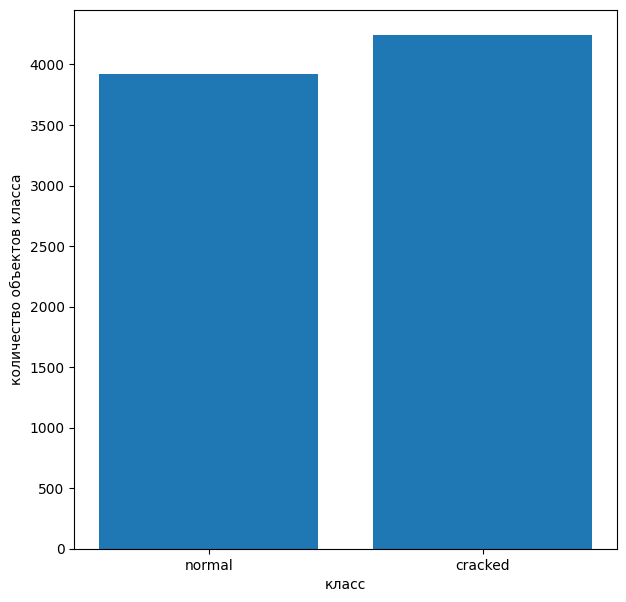

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))

classes = ['normal', 'cracked']
nums = [len(normal_files), len(cracked_files)]

ax.bar(classes, nums)
plt.xlabel('класс')
plt.ylabel('количество объектов класса')

plt.show()

In [5]:
splitfolders.ratio("tire_textures", output="splitted_data", seed=1337, ratio=(.7, .0, .3))

In [4]:
train_dataset = './splitted_data_1/train/'
test_dataset = './splitted_data_1/test/'

ПОДГОТОВКА ДАННЫХ ДЛЯ НЕЙРОСЕТИ

In [5]:
def images_with_labels(folder):

    imgs = []
    target = 1  # damaged = 1, normal = 0
    labels = []
    list_dir = os.listdir(folder)
    for cur in range(len(list_dir)):
        if list_dir[cur].startswith(('.')):
            list_dir.pop(cur)
            break

    for i in list_dir:
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            if not j.endswith(('.jpg')):
                continue
            else:
                img_dir = os.path.join(subdir, j)
                img = cv2.imread(img_dir)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128, 128))
                imgs.append(img)
                labels.append(target)
        target -= 1

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [6]:
train_data, train_labels = images_with_labels(train_dataset)
print(f"Train images shape = {train_data.shape}, \nlabels = {train_labels.shape}")

Train images shape = (10960, 128, 128), 
labels = (10960,)


In [19]:
test_data, test_labels = images_with_labels(test_dataset)
print(f"Test images shape = {test_data.shape}, \nlabels = {test_labels.shape}")

Test images shape = (4744, 128, 128), 
labels = (4744,)


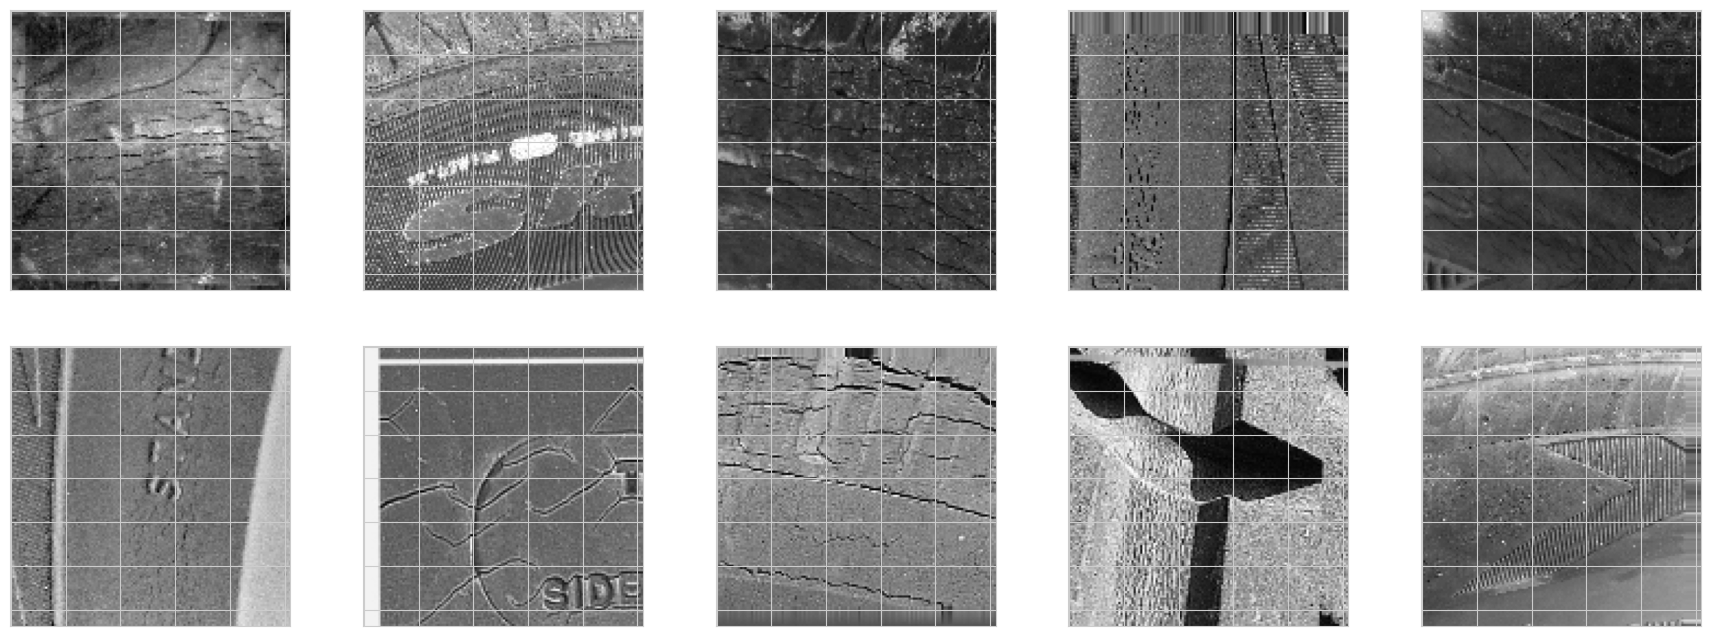

In [25]:
train_data = train_data / 255.0
train_data = np.expand_dims(train_data, axis = 3)
# axis = 3 new dimension added to 4th position & 1 because grayscale

МОДЕЛЬ

In [13]:
model = Sequential([
    Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = 3, padding = 'same'),
    Conv2D(32, 3, padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = 3, padding = 'same'),
    Conv2D(32, 3, activation = 'relu'),
    MaxPooling2D(3),
    Conv2D(16, 2, activation = 'relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])


# 2. compile
model.compile(loss = BinaryCrossentropy(),
              optimizer = Adam(),
              metrics = ["accuracy"])

# 3. fit
history = model.fit(train_data, train_labels, epochs = 15, validation_split = 0.3)

Epoch 1/15
240/240 [==============================] - 41s 167ms/step - loss: 0.5649 - accuracy: 0.7420 - val_loss: 1.0692 - val_accuracy: 0.0000e+00
Epoch 2/15
240/240 [==============================] - 39s 163ms/step - loss: 0.5485 - accuracy: 0.7418 - val_loss: 1.1601 - val_accuracy: 0.0030
Epoch 3/15
240/240 [==============================] - 39s 162ms/step - loss: 0.5184 - accuracy: 0.7481 - val_loss: 1.0473 - val_accuracy: 0.2274
Epoch 4/15
240/240 [==============================] - 39s 162ms/step - loss: 0.4834 - accuracy: 0.7654 - val_loss: 0.7159 - val_accuracy: 0.5765
Epoch 5/15
240/240 [==============================] - 39s 161ms/step - loss: 0.4523 - accuracy: 0.7824 - val_loss: 1.3592 - val_accuracy: 0.0821
Epoch 6/15
240/240 [==============================] - 39s 161ms/step - loss: 0.4075 - accuracy: 0.8118 - val_loss: 0.6897 - val_accuracy: 0.5816
Epoch 7/15
240/240 [==============================] - 39s 161ms/step - loss: 0.3701 - accuracy: 0.8278 - val_loss: 0.8735 - va

In [14]:
test_data = test_data / 255.0
test_data = np.expand_dims(test_data, axis = 3)

In [22]:
model.evaluate(train_data, train_labels)

343/343 [==============================] - 16s 45ms/step - loss: 0.2382 - accuracy: 0.9101


[0.23820269107818604, 0.9101277589797974]

In [15]:
model.evaluate(test_data, test_labels)

149/149 [==============================] - 7s 45ms/step - loss: 0.2706 - accuracy: 0.8914


[0.2705693542957306, 0.891441822052002]

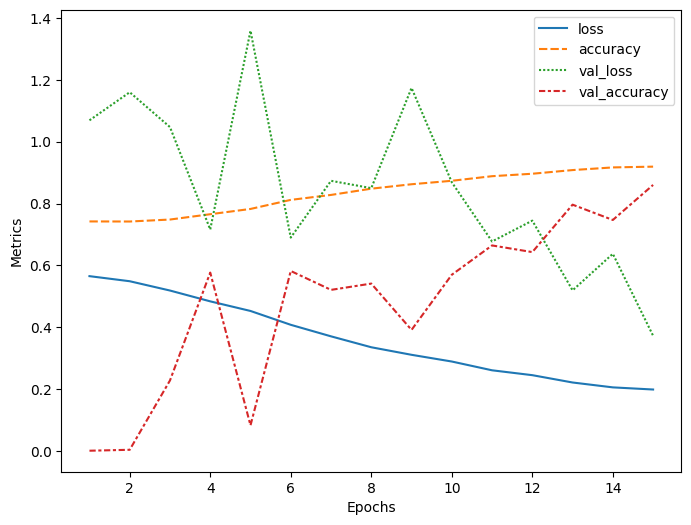

In [21]:
import seaborn as sns

plt.subplots(figsize = (8, 6))
sns.lineplot(data=pd.DataFrame(history.history, index=range(1, 16)))
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.show()

In [23]:
model.save("./custom_model/model.h5")